# OpenStreetMap Road Network Data Download and Processing
This notebook 
* extracts road network for the study area from OpenStreetMap (OSM)
* consolidate intersection to simplify the road network
* save the road network as 1. Graph, 2. network nodes as shapefile, 3. network edges as shapefile. 

In [2]:
from cflp_function import store_data_to_pickle
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

c:\Users\User\anaconda3\envs\scip\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
%matplotlib inline
ox.settings.log_console=True
ox.__version__

'1.8.1'

## 1. Download and Load OSM Street Network Data

In [8]:
# Load the Twente Boundary shapefile
shapefile_path = "/Users/User/Desktop/BIOZE/data/gemeente_and_boundaries/twente_buffer_8km.shp"
#'/Users/wenyuc/Desktop/UT/bioze_digital_mapping_tool/data/Twente_boundaries/Boundaries_Twente.shp'

In [9]:
twente = gpd.read_file(shapefile_path)

In [10]:
# coordinates should be in unprojected latitude-longitude degrees (EPSG:4326).
twente = twente.to_crs(epsg=4326)

In [7]:
polygon = twente['geometry'].squeeze()

In [8]:
# create customer filter 
# only main roads are needed
cf = '["highway"]["area"!~"yes"]["access"!~"private"]["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|road"]'

In [21]:
# create graph from polygon of Twente
G_base = ox.graph_from_polygon(polygon, network_type='drive', custom_filter=cf)

In [22]:
G_base = ox.project_graph(G_base, to_crs="EPSG:3857")

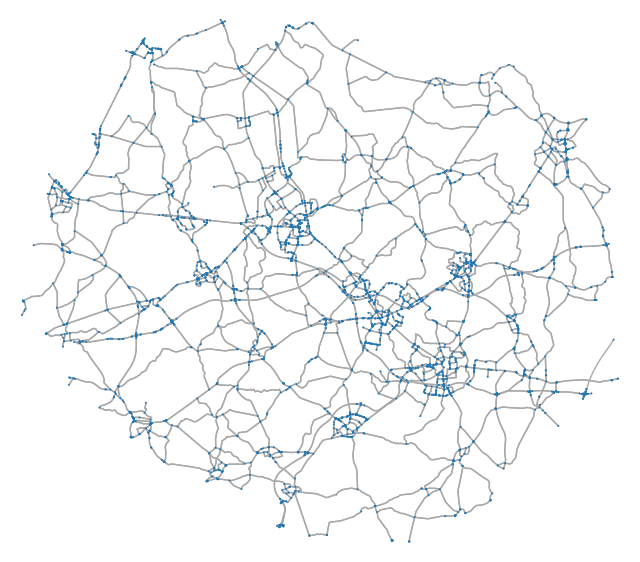

In [29]:
fig, ax = ox.plot_graph(G_base, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# fig.savefig('./notebook_figures/G.eps',format='eps', dpi=1000,bbox_inches="tight")
fig.savefig("./G_base.png", format = 'png', dpi= 1000, bbox_inches="tight")

In [26]:
len(G_base.nodes)

4114

In [24]:
# consolidate intersection to further simplify the topography of the graph
G = ox.consolidate_intersections(G_base, tolerance=200, rebuild_graph=True, dead_ends=False)

In [27]:
len(G.nodes)

1050

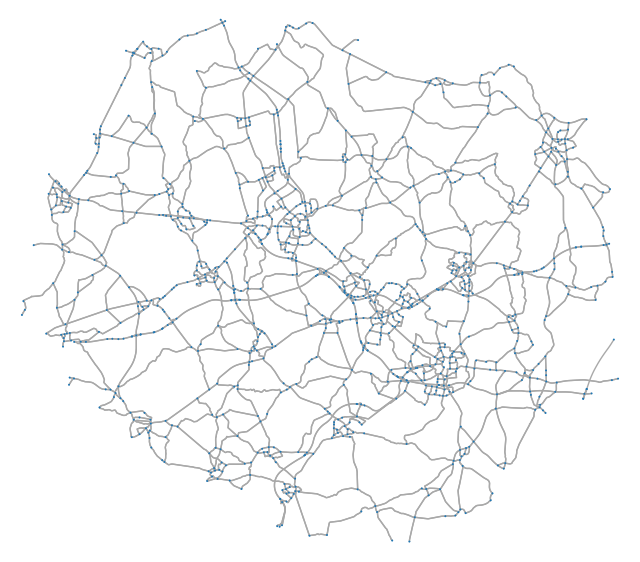

In [28]:
fig, ax = ox.plot_graph(G, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# fig.savefig('./notebook_figures/G.eps',format='eps', dpi=1000, bbox_inches="tight")
fig.savefig("./G.png", format = 'png', dpi= 1000, bbox_inches="tight") #transparent=True

In [52]:
ox.save_graphml(G, filepath="./osm_network/G.graphml", gephi=False)

In [53]:
# # save graph as a geopackage
# ox.save_graph_geopackage(G, filepath="./osm_network/G.gpkg")

In [54]:
# # save graph to disk as .osm xml file
# ox.settings.all_oneway = True
# ox.settings.log_console = True
# ox.save_graph_xml(G, filepath="./osm_network/G.osm")

In [61]:
n, e = ox.graph_to_gdfs(G)

In [57]:
n[["geometry", "y", "x", "lon", "lat", "highway"]].to_file("./osm_network/G_n.shp")

In [28]:
# Convert lists to strings
e['highway'] = e['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
e[["geometry","highway"]].to_file("./osm_network/G_e.shp")

## Plotting

In [4]:
n = gpd.read_file("./osm_network/G_n.shp")
e = gpd.read_file("./osm_network/G_e.shp")

In [5]:
t = gpd.read_file("/Users/User/Desktop/BIOZE/data/gemeente_and_boundaries/twente_boundaries/Boundaries_Twente.shp")

In [6]:
n = n.to_crs("EPSG:4326")
e = e.to_crs("EPSG:4326")
t = t.to_crs("EPSG:4326")

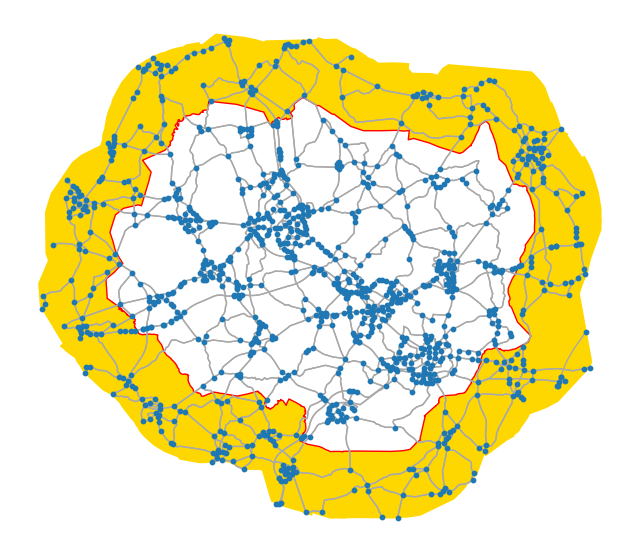

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
twente.plot(ax=ax, color='gold', zorder=1)
t.plot(ax=ax, edgecolor='red', color="white", zorder=2)
e.plot(ax=ax, color='darkgray', linewidth=1, zorder=3)
n.plot(ax=ax, color='tab:blue',  markersize=10, zorder=4)

ax.set_axis_off()
plt.show()
fig.savefig("/Users/User/Desktop/BIOZE/Latex_Bioze/Diagram/osm_network.png", format = 'png', dpi= 1000, bbox_inches="tight") #transparent=True
fig.savefig("/Users/User/Desktop/BIOZE/Latex_Bioze/Diagram/osm_network.eps",format='eps', dpi=1000, bbox_inches="tight")

## 2. Farms to Nodes (QGIS)

## 3. Create OD Matrix
Inputs:
* Road network with farm information at nodes 
* Set of potential digester locations 

In [2]:
g = ox.load_graphml('./osm_network/G.graphml') 

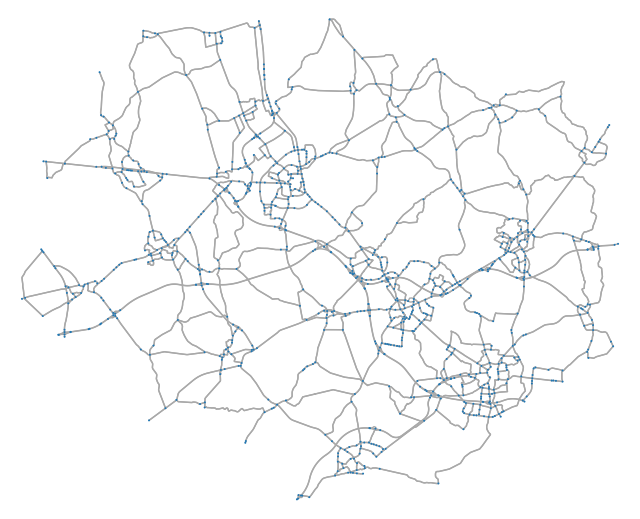

In [3]:
fig, ax = ox.plot_graph(g, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
# fig.savefig('./notebook_figures/G.eps',format='eps', dpi=1000,bbox_inches="tight")
# fig.savefig("./notebook_figures/G.png", format = 'png', dpi= 1000, bbox_inches="tight")

In [4]:
n, e = ox.graph_to_gdfs(g)

In [5]:
farm = pd.read_csv('./farm_mock.csv')
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [6]:
nearest_neighbor = pd.read_csv('./osm_network/nearest_neighbor.csv')
nearest_neighbor.head()

,InputID,TargetID,Distance
0,507920,528,286.673776
1,507950,845,811.058871
2,507953,655,949.973658
3,507962,855,1048.825422
4,507964,195,662.103623


In [7]:
potential_plant_location = pd.read_csv('./farm_cluster_mock_5.csv')

In [8]:
potential_plant_location_gdf = gpd.GeoDataFrame(potential_plant_location, geometry=gpd.points_from_xy(potential_plant_location.x, potential_plant_location.y), crs="EPSG:4326")

In [9]:
potential_plant_location_gdf.to_file('./osm_network/potential_plants.shp')

In [10]:
nearest_neighbor_p = pd.read_csv('./osm_network/nearest_neighbor_p.csv')

In [11]:
potential_plant_location['osmid'] = nearest_neighbor_p['TargetID']

In [12]:
potential_plant_location

,x,y,count,osmid
0,6.870686,52.215190,25,125
1,6.554937,52.254895,25,190
2,6.730518,52.252885,42,134
3,6.914234,52.387401,18,975
4,6.664105,52.392622,32,790


In [13]:
nearest_neighbor = nearest_neighbor.rename(columns={"TargetID": "osmid"})

In [14]:
merged_df = pd.merge(farm, nearest_neighbor, how='left', left_on="IND_OBJ_NA", right_on='InputID')
merged_df.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3,InputID,osmid,Distance
0,0,6.765843,52.314139,507920,2454,957060.0,507920,528,286.673776
1,1,6.837249,52.425084,507950,9827,3832530.0,507950,845,811.058871
2,2,6.859361,52.386225,507953,8660,3377400.0,507953,655,949.973658
3,3,6.753483,52.434382,507962,2913,1136070.0,507962,855,1048.825422
4,4,6.484077,52.243620,507964,6488,2530320.0,507964,195,662.103623


In [15]:
orig = merged_df['osmid'].unique().tolist()

In [16]:
dest = potential_plant_location['osmid'].unique().tolist()

In [17]:
# Initialize an empty OD matrix
od_matrix = {}

In [122]:
# Calculate and store the total travel distance of the shortest path between each origin and destination
# dictionary structure should be destination then plant due to the cflp demand
# for destination in dest:
#     od_matrix[destination] = {}
#     for origin in orig:
#         distance = nx.shortest_path_length(G, origin, destination, weight='length')
#         od_matrix[destination][origin] = distance/1000 # convert from m to km

In [19]:
for origin in orig:
    od_matrix[origin] = {}
    for destination in dest:
        distance = nx.shortest_path_length(g, origin, destination, weight='length')
        od_matrix[origin][destination] = distance/1000 # convert from m to km

In [20]:
merged_df['osmid'].value_counts()

osmid
845    6
486    4
961    4
333    3
739    3
      ..
874    1
150    1
54     1
578    1
505    1
Name: count, Length: 99, dtype: int64

In [21]:
od_matrix

{528: {125: 24.38013393505244,
  190: 27.69527117195013,
  134: 15.593838742840918,
  975: 23.62720894186127,
  790: 20.926694608852713},
 845: {125: 44.82143009758931,
  190: 53.405683876380735,
  134: 41.30425144727152,
  975: 11.393033134341938,
  790: 28.203696468836792},
 655: {125: 33.44961170516485,
  190: 42.03386548395628,
  134: 29.932433054847067,
  975: 9.288614629855118,
  790: 28.282320596118236},
 855: {125: 47.991572463088616,
  190: 48.83008561974004,
  134: 36.70906300701628,
  975: 20.77206655096697,
  790: 18.320085710548476},
 195: {125: 42.5459227986963,
  190: 8.540405399649853,
  134: 24.61503911992708,
  975: 57.84428951768395,
  790: 39.60958931797318},
 226: {125: 39.73493178519619,
  190: 5.729414386149746,
  134: 21.80404810642697,
  975: 57.04004226811188,
  790: 32.08841644590519},
 81: {125: 41.15047701292046,
  190: 7.144959613874018,
  134: 23.21959333415124,
  975: 58.455587495836156,
  790: 38.21414353219734},
 643: {125: 29.337833444619026,
  190: 4

In [22]:
# Initialize an empty nested dictionary
new_nested_dict = {}

In [23]:
# Create a new nested dictionary with DataFrame index as keys
for idx, row in merged_df.iterrows():
    osmid_value = row['osmid']
    if osmid_value in od_matrix:
        new_nested_dict[idx] = od_matrix[osmid_value]

In [24]:
# # Sample nested dictionary
# nested_dict = {
#     'key1': {'subkey1': 10, 'subkey2': 20},
#     'key2': {'subkey1': 30, 'subkey2': 40}
# }

# Transform the nested dictionary
transportation_cost = {}
for outer_key, inner_dict in new_nested_dict.items():
    for inner_key, value in inner_dict.items():
        if inner_key not in transportation_cost:
            transportation_cost[inner_key] = {outer_key: value}
        else:
            transportation_cost[inner_key][outer_key] = value

In [25]:
transportation_cost = {i: transportation_cost[key] for i, key in enumerate(transportation_cost)}

In [26]:
# Print the new nested dictionary
print("New Nested Dictionary:")
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

New Nested Dictionary:
0: {0: 24.38013393505244, 1: 44.82143009758931, 2: 33.44961170516485, 3: 47.991572463088616, 4: 42.5459227986963, 5: 39.73493178519619, 6: 39.73493178519619, 7: 39.73493178519619, 8: 41.15047701292046, 9: 29.337833444619026, 10: 60.81339182995623, 11: 35.7884586839528, 12: 35.7884586839528, 13: 35.7884586839528, 14: 8.796940073272545, 15: 8.755954253178963, 16: 5.3600297097658895, 17: 6.883862946658534, 18: 6.957726149871625, 19: 10.03842681340373, 20: 12.144326369198728, 21: 44.82143009758931, 22: 41.54051845695836, 23: 6.286203099335466, 24: 17.9370599456493, 25: 30.200415744774368, 26: 14.677924810866942, 27: 16.845907393373054, 28: 17.94268674393164, 29: 12.723865117678855, 30: 22.693274345645236, 31: 28.922735935052437, 32: 45.500082945093155, 33: 25.016404311655535, 34: 25.984618478339137, 35: 35.85481511049894, 36: 36.260273110498936, 37: 24.703634513580283, 38: 31.076052701917913, 39: 21.01192676649167, 40: 15.925104529618213, 41: 17.497717906729996, 42: 

In [27]:
cost_per_km = 0.69

# Function to multiply values in nested dictionary by 0.69
def multiply_dict_values(d, cost_per_km = cost_per_km):
    for k, v in d.items():
        if isinstance(v, dict):
            multiply_dict_values(v)
        else:
            d[k] = v * cost_per_km

In [28]:
# Multiply all values in the nested dictionary by 0.69
multiply_dict_values(transportation_cost)

In [29]:
# Print the new nested dictionary
print("New Nested Dictionary:")
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

New Nested Dictionary:
0: {0: 16.822292415186183, 1: 30.92678676733662, 2: 23.080232076563743, 3: 33.11418499953114, 4: 29.356686731100446, 5: 27.41710293178537, 6: 27.41710293178537, 7: 27.41710293178537, 8: 28.393829138915116, 9: 20.243105076787128, 10: 41.9612403626698, 11: 24.694036491927427, 12: 24.694036491927427, 13: 24.694036491927427, 14: 6.069888650558055, 15: 6.041608434693484, 16: 3.6984204997384635, 17: 4.749865433194389, 18: 4.800831043411421, 19: 6.9265145012485725, 20: 8.379585194747122, 21: 30.92678676733662, 22: 28.662957735301266, 23: 4.337480138541471, 24: 12.376571362498016, 25: 20.83828686389431, 26: 10.127768119498189, 27: 11.623676101427407, 28: 12.380453853312831, 29: 8.77946693119841, 30: 15.658359298495212, 31: 19.95668779518618, 32: 31.395057232114276, 33: 17.261318975042318, 34: 17.929386750054004, 35: 24.739822426244267, 36: 25.019588446244263, 37: 17.045507814370396, 38: 21.44247636432336, 39: 14.49822946887925, 40: 10.988322125436566, 41: 12.073425355643

In [30]:
transportation_cost

{0: {0: 16.822292415186183,
  1: 30.92678676733662,
  2: 23.080232076563743,
  3: 33.11418499953114,
  4: 29.356686731100446,
  5: 27.41710293178537,
  6: 27.41710293178537,
  7: 27.41710293178537,
  8: 28.393829138915116,
  9: 20.243105076787128,
  10: 41.9612403626698,
  11: 24.694036491927427,
  12: 24.694036491927427,
  13: 24.694036491927427,
  14: 6.069888650558055,
  15: 6.041608434693484,
  16: 3.6984204997384635,
  17: 4.749865433194389,
  18: 4.800831043411421,
  19: 6.9265145012485725,
  20: 8.379585194747122,
  21: 30.92678676733662,
  22: 28.662957735301266,
  23: 4.337480138541471,
  24: 12.376571362498016,
  25: 20.83828686389431,
  26: 10.127768119498189,
  27: 11.623676101427407,
  28: 12.380453853312831,
  29: 8.77946693119841,
  30: 15.658359298495212,
  31: 19.95668779518618,
  32: 31.395057232114276,
  33: 17.261318975042318,
  34: 17.929386750054004,
  35: 24.739822426244267,
  36: 25.019588446244263,
  37: 17.045507814370396,
  38: 21.44247636432336,
  39: 14.498

In [32]:
store_data_to_pickle(transportation_cost, 'app_data', 'transportation_cost.pickle')

In [168]:
# export transportation_cost 
print("Started writing dictionary to a file")
with open("./transportation_cost.txt", "w") as fp:
    json.dump(transportation_cost, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

Started writing dictionary to a file
Done writing dict into .txt file


In [151]:
# # https://autogis-site.readthedocs.io/en/latest/notebooks/L3/04_nearest-neighbour.html
# def get_nearest_node_to_farm(row, node_gdf, point_column='geometry'):

#     # Create an union of the node GeoDataFrame's geometries
#     node = node_gdf['geometry'].unary_union

#     # Find the nearest node to each poi 
#     nearest_geoms = nearest_points(row[point_column], node)

#     # Get corresponding values from the node df 
#     nearest_node = node_gdf.loc[node_gdf['geometry'] == nearest_geoms[1]] 
#     nearest_value = nearest_node.index.values[0] # might need to change value_column to osmid 
#     #nearest_value = nearest_node[value_column].values[0] # might need to change value_column to osmid 

#     return nearest_value 

In [152]:
# def find_nearest_node(farm_point, node_gdf, point_column='geometry'):

#     # Create an union of the node GeoDataFrame's geometries
#     nodes = node_gdf['geometry'].unary_union

#     nearest_geom = nearest_points(farm_point[point_column], nodes)[1]

#     nearest_node = node_gdf[node_gdf['geometry'] == nearest_geom].index.values[0]
#     return nearest_node

In [153]:
# farm_gdp['nearest_n'] = farm_gdp.apply(find_nearest_node, node_gdf=n, point_column='geometry', axis=1)

In [154]:
# plt.figure(figsize=(8, 6))
# plt.scatter(potential_plant_location['x'], potential_plant_location['y'], alpha=0.5)
# plt.scatter(n['lon'], n['lat'], marker='^', c='black')